<a href="https://colab.research.google.com/github/yananma/5_programs_per_day/blob/master/0516.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 9.3 目标检测和边界框

In [0]:
!pip install mxnet-cu100 d2lzh

In [2]:
!git clone https://github.com/d2l-ai/d2l-zh.git

Cloning into 'd2l-zh'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15702 (delta 9), reused 8 (delta 4), pack-reused 15685
Receiving objects: 100% (15702/15702), 159.56 MiB | 34.62 MiB/s, done.
Resolving deltas: 100% (11132/11132), done.


In [0]:
!mkdir ../img

In [0]:
!cp ./d2l-zh/img/catdog.jpg ../img/

In [0]:
%matplotlib inline 
import d2lzh as d2l 
from mxnet import image

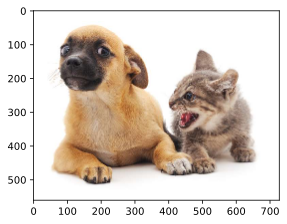

In [16]:
d2l.set_figsize(figsize=(5, 3.5))
img = image.imread('../img/catdog.jpg').asnumpy()
d2l.plt.imshow(img);

In [0]:
dog_bbox, cat_bbox = [60, 45, 378, 516], [400, 112, 655, 493]

In [0]:
def bbox_to_rect(bbox, color):
    return d2l.plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1], 
        fill=False, edgecolor=color, linewidth=2
    )

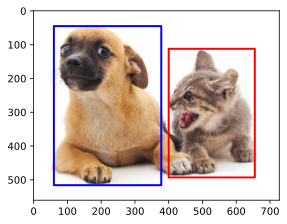

In [23]:
fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

## 9.4 锚框

In [0]:
%matplotlib inline 
import d2lzh as d2l 
from mxnet import contrib, gluon, image, nd 
import numpy as np 
np.set_printoptions(2)

In [26]:
img = image.imread('../img/catdog.jpg').asnumpy()
h, w = img.shape[0:2]

print(h, w)
X = nd.random.uniform(shape=(1, 3, h, w))
Y = contrib.nd.MultiBoxPrior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape 

561 728


(1, 2042040, 4)

In [27]:
boxes = Y.reshape((h, w, 5, 4))
boxes[250, 250, 0, :]


[0.06 0.07 0.63 0.82]
<NDArray 4 @cpu(0)>

In [0]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values 
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj 

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.asnumpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i], 
                 va='center', ha='center', fontsize=9, color=text_color, 
                 bbox=dict(facecolor=color, lw=0))

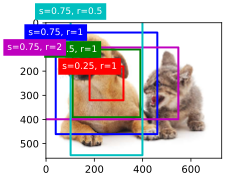

In [30]:
d2l.set_figsize()
bbox_scale = nd.array((w, h, w, h))
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale, 
      ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2', 's=0.75, r=0.5'])

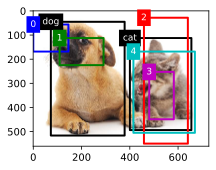

In [31]:
ground_truth = nd.array([[0, 0.1, 0.08, 0.52, 0.92], 
              [1, 0.55, 0.2, 0.9, 0.88]])
anchors = nd.array([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4], 
            [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8], 
            [0.57, 0.3, 0.92, 0.9]])

fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

In [0]:
labels = contrib.nd.MultiBoxTarget(anchors.expand_dims(axis=0), 
                            ground_truth.expand_dims(axis=0), 
                            nd.zeros((1, 3, 5)))

In [33]:
labels[2]


[[0. 1. 2. 0. 2.]]
<NDArray 1x5 @cpu(0)>

In [34]:
labels[1]


[[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.]]
<NDArray 1x20 @cpu(0)>

In [35]:
labels[0]


[[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.40e+00  1.00e+01  2.59e+00
   7.18e+00 -1.20e+00  2.69e-01  1.68e+00 -1.57e+00  0.00e+00  0.00e+00
   0.00e+00  0.00e+00 -5.71e-01 -1.00e+00 -8.94e-07  6.26e-01]]
<NDArray 1x20 @cpu(0)>

In [0]:
anchors = nd.array([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95], 
            [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = nd.array([0] * anchors.size)
cls_probs = nd.array([[0] * 4, [0.9, 0.8, 0.7, 0.1], [0.1, 0.2, 0.3, 0.9]])

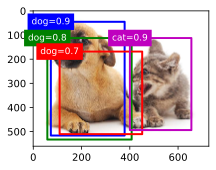

In [39]:
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale, ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

In [41]:
output = contrib.nd.MultiBoxDetection(
    cls_probs.expand_dims(axis=0), offset_preds.expand_dims(axis=0), 
    anchors.expand_dims(axis=0), nms_threshold=0.5
)
output


[[[ 0.    0.9   0.1   0.08  0.52  0.92]
  [ 1.    0.9   0.55  0.2   0.9   0.88]
  [-1.    0.8   0.08  0.2   0.56  0.95]
  [-1.    0.7   0.15  0.3   0.62  0.91]]]
<NDArray 1x4x6 @cpu(0)>

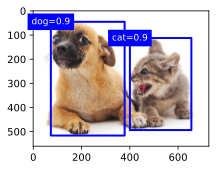

In [42]:
fig = d2l.plt.imshow(img)
for i in output[0].asnumpy():
    if i[0] == -1:
        continue 
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [nd.array(i[2:]) * bbox_scale], label)

## 9.5 多尺度目标检测

In [43]:
%matplotlib inline 
import d2lzh as d2l 
from mxnet import contrib, image, nd 

img = image.imread('../img/catdog.jpg')
h, w = img.shape[0:2]
h, w

(561, 728)

In [0]:
d2l.set_figsize()

def display_anchors(fmap_w, fmap_h, s):
    fmap = nd.zeros((1, 10, fmap_w, fmap_h))
    anchors = contrib.nd.MultiBoxPrior(fmap, sizes=s, ratios=[1, 2, 0.5])
    bbox_scale = nd.array((w, h, w, h))
    d2l.show_bboxes(d2l.plt.imshow(img.asnumpy()).axes, anchors[0] * bbox_scale)

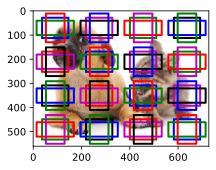

In [45]:
display_anchors(fmap_w=4, fmap_h=4, s=[0.15])

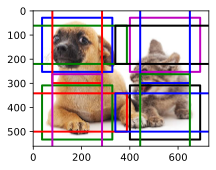

In [46]:
display_anchors(fmap_w=2, fmap_h=2, s=[0.4])

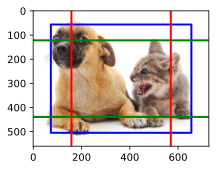

In [49]:
display_anchors(fmap_w=1, fmap_h=1, s=[0.8])